# Introduction à dask grâce aux données DVF

Pour essayer les exemples présents dans ce tutoriel :

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABnotebooks/course/manipulation/07_dask.ipynb%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=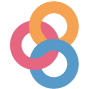" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/manipulation/07_dask.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

La documentation complète sur `Dask` se trouve sur <https://docs.dask.org/>.

Le projet requiert l’installation de `dask`. Afin d’avoir
la distribution complète on utilise la commande suivante:

``` shell
pip install dask[complete]
```

# Pourquoi utiliser `Dask` ?

On peut se référer à la page https://docs.dask.org/en/stable/why.html

Plusieurs points sont mis en avant dans la documentation officielle et sont résumés ci-dessous:
- `Dask` ressemble fortement en termes de syntaxe à `pandas` et `numpy` ;
- `Dask` peut être utilisé sur un ordinateur seul ou sur un *cloud cluster*. Avec `Dask`, on peut traiter des bases de 100GB sur un ordinateur portable, voire même 1TB sans même avoir besoin d’un cluster *big data* ;
- `Dask` requiert peu de temps d’installation puisqu’il peut être installé avec le gestionnaire de *packages* `conda` (il est même livré dans la distribution par défaut d’Anaconda)

## Comment `Dask` se compare à `Spark` ?

Dans le monde du *big-data*, un écosystème concurrent existe: [`Spark`](https://spark.apache.org/).

-   `Spark` est écrit en `Scala` à l’origine. Le package [`pyspark`](https://spark.apache.org/docs/latest/api/python/) permet d’écrire en `Python` et s’assure de la traduction en `Python` afin d’interagir avec les machines virtuelles `Java` (JVM) nécessaires pour la parallélisation des opérations `Spark`. `Dask` est quant à lui écrit en Python, ce qui est un écosystème plus léger. Pour gagner en performance, il permet d’interagir avec du code C/C++ entre autres ;
-   L’installation de `Spark` est plus lourde que celle de `Dask`
-   `Spark` est un projet Apache en lui-même alors que `Dask` intervient comme une composante de l’univers `Python`;
-   `Spark` est un peu plus vieux (2010 versus 2014 pour `Dask`) ;
-   `Spark` permet de très bien faire des opérations classiques SQL et des ETLs, et proposer ses propres librairies de parallélisation de modèles de *machine learning*. Pour faire du *machine learning* avec `Spark` il faut aller piocher dans `Spark MLLib`. `Dask` permet quant à lui de bien interagir avec `scikit-learn` et de faire de la modélisation.

Globalement, il faut retenir que `Dask` comme `Spark` ne sont intéressants que pour des données dont le traitement engendre des problèmes de RAM. Autrement, il
vaut mieux se contenter de `pandas`.

# Démonstration de quelques *features* de `Dask`

Nous allons utiliser les [données immobilières `DVF`](https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/) pour montrer quelques éléments clefs de `Dask`.

In [2]:
# Import dvf files 
import pandas as pd
import dask.dataframe as dd

def import_dvf():
    d_urls = {"2019" : 'https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2',
                 "2020" : "https://www.data.gouv.fr/fr/datasets/r/90a98de0-f562-4328-aa16-fe0dd1dca60f",
                 "2021": "https://www.data.gouv.fr/fr/datasets/r/817204ac-2202-4b4a-98e7-4184d154d98c"}
    dfs = {}
    for k in d_urls.keys():
        dfs[k] = pd.read_csv(d_urls[k], sep = "|", decimal=",")
        dfs[k]["year"] = k
    df = pd.concat(dfs).reset_index()
    df = df.drop(["level_0", "level_1"], axis=1)
    return df

Dans un premier temps, on va utiliser `pandas` pour
importer nos données, ces dernières tenant en mémoire
sur un ordinateur normalement doté en RAM:

In [3]:
dvf = import_dvf()
dvf.shape
dvf.head()

Ici on travaille sur un `DataFrame` d’environ 10 millions de lignes et 44 variables.
L’objet `dvf` est un `pandas.DataFrame`
qui tient en mémoire sur le SSP-Cloud.

<div class="alert alert-success" role="alert">

On aurait pu lire directement les csv dans un `dask.DataFrame` avec le `read_csv` de `dask`. Comme exercice, vous pouvez essayer de le faire.

</div>

On peut créer une structure `Dask` directement à partir d’un `DataFrame` `pandas` avec la méthode `from_pandas`.

In [4]:
dvf_dd = dd.from_pandas(dvf, npartitions=10) 
dvf_dd

Pour souligner la différence avec un `pandas.DataFrame`,
l’affichage diffère. Seule la structure du `dask.DataFrame`
est affichée et non son contenu car les données
`dask` ne sont pas chargées en mémoire.

<div class="alert alert-danger" role="alert">

Attention, `Dask` ne peut créer un `Dask.DataFrame` à partir d’un `pandas.DataFrame` multi-indexé.

Dans ce cas il a fallu faire un `reset_index()` pour avoir un unique index.

</div>

On a ainsi la structure de notre `dask.DataFrame`, soit environ 10M de lignes, avec 44 colonnes en 10 partitions, soit environ 1M d’observations par partition.
`Dask`, comme `Spark` et en fait comme la plupart des *frameworks* permettant de
traiter des données plus volumineuses que la RAM disponible,
repose sur le principe du partitionnement et de la parallélisation
des opérations. Les données ne sont jamais importées dans leur
ensemble mais par bloc. Un plan des opérations à effectuer est
ensuite appliquer sur chaque bloc (nous reviendrons
sur ce principe), indépendamment. La particularité de `Dask`,
par rapport à `Spark`,
est que chaque bloc est un `pandas.DataFrame`, ce qui
rend très facile l’application de manipulations de données
traditionnelles sur des sources volumineuses:

![](https://docs.dask.org/en/stable/_images/dask-dataframe.svg)

<div class="alert alert-warning" role="alert">

Le choix du nombre de partition (10) est arbitraire ici. Bien qu’on puisse
trouver des règles du pouce pour fixer un nombre optimal de
partitions, cela dépend de beaucoup de facteurs et, en pratique,
rien ne remplace l’essai-erreur. Par exemple, [la documentation `Dask` recommande des blocs d’environ
100MB](https://docs.dask.org/en/stable/dataframe-best-practices.html)
ce qui peut convenir pour des ordinateurs à la RAM limitée mais n’a pas
forcément de sens pour des machines ayant 16GB de RAM.
Un nombre important de partition va permettre de faire des opérations
sur des petits blocs de données, ce qui permettra de gagner en vitesse
d’exécution. Le prix à payer est beaucoup *d’input/output* car
`Dask` va passer du temps à lire beaucoup de blocs de données et écrire
des bases intermédiaires.

</div>

On peut accéder aux index que couvrent les partitions de la manière suivante:

In [5]:
dvf_dd.divisions

Et on peut directement accéder à une partition grâce aux crochets `[]`:

In [7]:
dvf_dd.partitions[0]

`Dask` fait de la *“lazy evaluation”*. Cela signifie que le résultat n’est calculé que si on le demande explicitement. Dans le cas, contraire, ce que l’on appelle un `dask` **task graph** est produit (on verra plus bas comment voir ce *graph*).
Pour demander explicitement le résultat d’un calcul, il faut utiliser `compute`. Par exemple, pour afficher le contenu des 100 premières lignes :

In [8]:
dvf_dd.loc[0:100,:].compute()

Ce qui est pratique avec `dask.dataframe` c’est que de nombreuses méthodes sont semblables à celles de `pandas`. Par exemple, si l’on souhaite connaitre les types de locaux présents dans la base en 2019:

In [9]:
dvf_dd.loc[:,"Type local"].value_counts().compute()

A titre de comparaison, comparons les temps de calculs entre `pandas` et `dask` ici:

In [10]:
import timeit
start_time = timeit.default_timer()
dvf_dd.loc[:,"Type local"].value_counts().compute()
print(timeit.default_timer() - start_time)

In [11]:
start_time = timeit.default_timer()
dvf.loc[:,"Type local"].value_counts()
print(timeit.default_timer() - start_time)

On se rend compte que le `pandas DataFrame` a un temps de calcul plus court, mais c’est parce que `dask` va nous servir avant tout à lire des bases dont le traitement excède notre RAM. Donc, cette comparaison n’existera tout simplement pas car le `pandas DataFrame` n’aura pas été chargé en RAM. **On voit dans cet exemple que lorsque le traitement du `DataFrame` tient en RAM, l’utilisation de `dask` est inutile**.

Les méthodes dans `dask` peuvent etre chainées, comme dans `pandas`, par exemple, on pourra écrire:

In [12]:
mean_by_year = dvf_dd.loc[~dvf_dd["Surface terrain"].isna(),["Surface terrain", "year"]].groupby("year").mean()

In [13]:
mean_by_year.compute()

Afin de visualiser le *graph* de computation de `dask`, on peut utiliser `dask` de la manière suivante. On voit ainsi toutes les étapes que jusqu’ici `dask` n’a pas *executé* et qu’il va devoir exécuter pour calculer le résultat (`compute()`), en l’occurence l’étape `from_pandas()`, le `getitem`, `isna`, `inv` et `loc-series` qui résultent de nos filtres sur le `DataFrame`, et ensuite on voit les étapes de `groupby` et que pour calculer la moyenne il convient de faire la somme et la division. Toutes ces étapes vont être effectuées quand on appelle `compute()` et pas avant (*lazy evaluation*).

In [14]:
mean_by_year.dask # permet de visualiser le task graph pour obtenir le résultat

Afin de voir la structure du `dask DataFrame` on peut utilise la méthode `visualize()`:

In [15]:
dvf_dd.visualize() # attention graphviz est requis

Il faut savoir que `dask` produit des `Array`, `Bag` et `DataFrames`, qui fonctionnent comme dans `numpy` et `pandas` (il est possible de créer d’autres structures ad hoc, cf plus loin). Intéressons nous tout d’abord au `dask` `DataFrame` qui est ce que l’on manipule depuis le début de ce notebook. On peut penser à un `dask DataFrame` comme à un ensemble de nombreux `pandas DataFrame` pouvant tenir en RAM séparé grâce à l’index. Une opération sur un `dask DataFrame` entraine autant d’opérations sur les multiples `pandas DataFrame`. Ces opérations se font potentiellement en parallèle en tenant compte de la mémoire disponible. Le site de `dask` cite une règle qui est la suivante : *“Have 5 to 10 times as much RAM as the size of your dataset”*,Wes McKinney (2017) in *10 things I hate about pandas*. (size = size on the disk) <https://wesmckinney.com/blog/apache-arrow-pandas-internals/>

Regardons la taille de notre base actuelle (on l’exporte en S3).

In [16]:
import s3fs

def export2minio(filename, df_final):
    endpoint = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': endpoint})
    bucket = "radjerad/diffusion/dvf"
    path_out = bucket + "/" + filename

    with fs.open(path_out, 'w') as file_out:
        df_final.to_csv(file_out, index=False, encoding="utf-8", sep=";")
    return None

In [17]:
export2minio("dvf_2019_2021.csv", dvf) 

Le fichier fait 1,4 giga. Si l’on suit la règle du pouce donnée plus haut, on va avoir besoin d’une RAM d’au moins environ 7-14 gigas (en fonction de nos traitements). Donc c’est seulement si l’on est contraint en dessous de ce niveau de RAM qu’il va être intéressant de faire appel à `dask`.

A noter que certaines méthodes vont déclencher un `compute` directement, comme par exemple `len` ou `head`.

In [18]:
len(dvf_dd)

In [19]:
dvf_dd.head()

#### Problèmes de lecture dus à des types problématiques

La méthode `read_csv` de `dask` va inférer les types du `DataFrame` à partir d’échantillon, et va les implémenter sur tout le `DataFrame` seulement au moment d’une étape `compute`.
Il peut donc y avoir des erreurs de types dûs à un échantillon ne prenant pas en compte certains cas particuliers, causant des erreurs dans la lecture du fichier. Dans ce cas (et comme de manière générale avec `pandas`), il peut être recommandé de faire appel au paramètre `dtype` de `read_csv` - qui est un `dict` - (la doc de `dask` nous dit aussi que l’on peut augmenter la taille de l’échantllon `sample`).

#### Utiliser `dask` avec le format parquet

`dask` permet de lire le format parquet, et plus précisément d’utiliser des fonctionnalités spécifiques à ce format. La lecture et l’écriture en parquet reposent par défaut sur `pyarrow`. On peut aussi utiliser `fastparquet` et préciser dans la lecture/écriture ce que l’on souhaite des deux.

In [20]:
dvf_net = dvf.loc[:,[ 'Date mutation', 'Nature mutation', 'Valeur fonciere', 'Commune', 
       'Code commune', 'Type local', 'Identifiant local', 'Surface reelle bati',
       'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain', 'year']]

In [21]:
dvf_net.to_parquet("../data/dvf/", partition_cols="year") # pour ceci il faut pyarrow, à noter que to_parquet fonctionne 
# aussi sur les dask DataFrame, ici on partitionne selon l'année

In [22]:
dvf_dd = dd.read_parquet("../data/dvf/year=2019/", columns=["Date mutation", "Valeur fonciere"]) # On peut sélectionner directement les deux colonnes

In [23]:
dvf_dd.head()

#### A quoi sert `persist` ?

Il est possible de garder une partie des données en mémoire avec `persist()`. Les données sont sauvegardées dans des objets appelés `Futures`. Cela peut être intéressant si un bloc particulier de données est utilisé dans plusieurs `compute` ou si l’on a besoin de voir ce qu’il y a à l’intérieur souvent.

In [24]:
dvf_dd_mem = dvf_dd.persist()

In [25]:
%%time
dvf_dd_mem.head()

In [26]:
%%time
dvf_dd.head()

On a bien un temps plus important avec le `dask DataFrame` initial, comparé avec celui sur lequel on a utilisé `persist`.

Il existe un autre objet `dask`, les `Array` pour reprendre la logique de `numpy`. De la même manière qu’un `dask DataFrame` est en quelque sorte un ensemble de `pandas DataFrame`, un `dask Array` est un ensemble de `numpy Array` qui sont plus importants en taille que la RAM. On pourra utiliser les opérations courantes `numpy` avec `dask` de la même manière que le `dask DataFrame` réplique la logique du `pandas DataFrame`.

#### **Aller plus loin**: Utiliser le decorator `dask.delayed` pour paralléliser du code

Il est possible de paralléliser des fonctions par exemple en utilisant le **decorator** `dask.delayed`. Cela permet de rendre les fonctions `lazy`, lorsque l’on appelle la fonction, un delayed object est construit, pour avoir le résultat il faut faire un `compute`. Pour aller plus loin: <https://tutorial.dask.org/03_dask.delayed.html>.

In [27]:
import dask
import time 
# voici le resultat sans le decorator
def aire_carre(longueur):
    time.sleep(1)
    return longueur**2

def perimetre_carre(longueur):
    time.sleep(1)
    return 4*longueur

def ajout_aire_perim(a, b):
    return a + b
start_time = timeit.default_timer()
car1 = aire_carre(7)
car2 = perimetre_carre(9)
car3 = ajout_aire_perim(car1, car2)
car3
print(timeit.default_timer() - start_time)

In [28]:
@dask.delayed
def aire_carre(longueur):
    time.sleep(1)
    return longueur**2

@dask.delayed
def perimetre_carre(longueur):
    time.sleep(1)
    return 4*longueur

@dask.delayed
def ajout_aire_perim(a, b):
    return a + b

In [29]:
car1 = aire_carre(7)
car2 = perimetre_carre(9)
car3 = ajout_aire_perim(car1, car2)

Mais en fait rien n’a été calculé, si l’on souhaite le résultat, il faut appeler `compute`

In [30]:
import timeit
start_time = timeit.default_timer()
car3.compute()
print(timeit.default_timer() - start_time)

Ici l’intérêt est assez limité, mais on voit que l’on réduit quand même de 2 à 1 seconde le temps de calcul. Mais l’idée derrière est que l’on a transformé `car3` en un objet `Delayed`. Cela a généré un `task graph` permettant de paralléliser certaines opérations. Ici il est important de noter que les fonctions que l’on parallélise doivent mettre un certain temps, sinon il n’y aura pas de gain de performance (si on retire le `time.sleep` il n’y a pas de gain de performance car le fait de paralléliser rajoute en fait du temps vu que chaque fonction a un temps de calcul trop faible pour que la parallélisation soit intéressante).

In [31]:
car3.visualize() # on peut visualiser le task graph et voir ce qui est fait en parallèle 

Il y a des exercices intéressants dans la doc de `dask` sur les objets `Delayed`, notamment sur la parallélisation de séquence de traitement de données. Ils donnent l’exemple d’un ensemble de csv ayant le même format dont on veut résumer un indicateur final. On peut appliquer le decorator à une fonction permettant de lire le csv, puis utiliser une boucle for pour lire le ficher et appliquer les traitements. Ensuite, il faudra appeler compute sur l’objet final que l’on souhaite.

Pour aller plus loin sur l’utilisation de `dask` sur un cluster voir <https://tutorial.dask.org/04_distributed.html>.

# Remerciements

Ce chapitre a été rédigé avec [Raphaële Adjerad](https://github.com/raphaeleadjerad).